In [82]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [83]:
import tensorflow as tf
devices = tf.config.experimental.list_physical_devices('GPU')
if devices:
    # If GPUs are available, enable memory growth on them
    for device in devices:
        tf.config.experimental.set_memory_growth(device, True)
    # Set the first GPU as visible
    tf.config.experimental.set_visible_devices(devices[0], 'GPU')
else:
    # If no GPUs are available, list all CPUs
    devices = tf.config.experimental.list_physical_devices('CPU')
    # Set the first CPU as visible (typically there's only one)
    tf.config.experimental.set_visible_devices(devices[0], 'CPU')
    
# plt increases the default figure size and
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 125
# tight_layout no axis 
plt.rcParams['axes.axisbelow'] = True

# Set seed for reproducibility
seed = 42

Path("images/CGAN").mkdir(parents=True, exist_ok=True)


In [84]:
dataset = keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = dataset

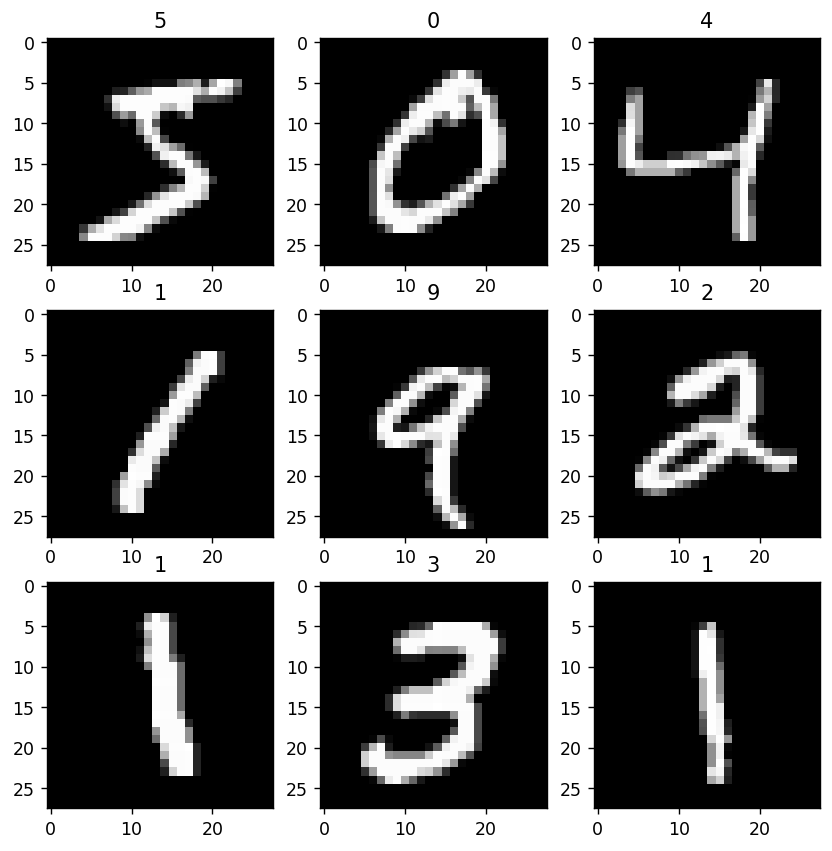

In [85]:

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])
    


In [86]:
rows, cols,channels = 28, 28, 1
img_shape = (rows, cols, channels)
noise_shape = (128,)
num_classes = 10

In [87]:
# Build Generator
def build_generator():
    noise = keras.layers.Input(shape=(noise_shape[0],))
    label = keras.layers.Input(shape=(1,), dtype="int32")
    label_embedding = keras.layers.Flatten()(
        keras.layers.Embedding(num_classes, noise_shape[0])(label)
    )

    model = keras.models.Sequential(
        [
            keras.layers.Dense(256, input_dim=noise_shape[0] * 2),
            keras.layers.LeakyReLU(alpha=0.2),
            keras.layers.BatchNormalization(momentum=0.8),
            keras.layers.Dense(512),
            keras.layers.LeakyReLU(alpha=0.2),
            keras.layers.BatchNormalization(momentum=0.8),
            keras.layers.Dense(1024),
            keras.layers.LeakyReLU(alpha=0.2),
            keras.layers.BatchNormalization(momentum=0.8),
            keras.layers.Dense(np.prod(img_shape), activation="tanh"),
            keras.layers.Reshape(img_shape),
        ]
    )
    model_input = keras.layers.Concatenate()([noise, label_embedding])
    img = model(model_input)

    return keras.Model([noise, label], img, name="generator")


# Build Discriminator
def build_discriminator():
    img = keras.Input(shape=img_shape)
    label = keras.Input(shape=(1,), dtype="int32")

    label_embedding = keras.layers.Flatten()(
        keras.layers.Embedding(num_classes, np.prod(img_shape))(label)
    )
    flat_img = keras.layers.Flatten()(img)

    model_input = keras.layers.multiply([flat_img, label_embedding])

    model = keras.models.Sequential(
        [
            keras.layers.Dense(512, input_dim=np.prod(img_shape)),
            keras.layers.LeakyReLU(alpha=0.2),
            keras.layers.Dense(512),
            keras.layers.LeakyReLU(alpha=0.2),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(512),
            keras.layers.LeakyReLU(alpha=0.2),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    validity = model(model_input)
    return keras.Model([img, label], validity, name="discriminator")

In [88]:
# Hyperparameters
epochs = 100
batch_size = 32
save_interval = 10
half_batch = batch_size // 2
optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Build and compile the models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Combined model
noise = keras.Input(shape=noise_shape)
label = keras.Input(shape=(1,))
img = generator([noise, label])
discriminator.trainable = False
validity = discriminator([img, label])
combined = keras.Model([noise, label], validity)
combined.compile(optimizer=optimizer, loss="binary_crossentropy")

    
def save_imgs(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, noise_shape[0]))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(f"images/CGAN/mnist_{epoch}.png")
    plt.close()

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [89]:
valid = np.ones((half_batch, 1))
fake = np.zeros((half_batch, 1))
for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        imgs, labels = x_train[idx], y_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (half_batch, noise_shape[0]))

        # Generate a half batch of new images
        gen_imgs = generator.predict([noise, labels])

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Condition on labels
        sampled_labels = np.random.randint(0, 10, half_batch).reshape(-1, 1)

        # Train the generator
        g_loss = combined.train_on_batch([noise, sampled_labels], valid)

        # Plot the progress
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {np.mean(g_loss):.4f}]")

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.5598, acc.: 65.62%] [G loss: 0.5699]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


C:\Users\Dell\AppData\Local\Temp\ipykernel_16828\1365429912.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1 [D loss: 0.6146, acc.: 50.78%] [G loss: 0.5684]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2 [D loss: 0.6768, acc.: 45.73%] [G loss: 0.5947]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3 [D loss: 0.6255, acc.: 47.60%] [G loss: 0.5738]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4 [D loss: 0.6461, acc.: 47.12%] [G loss: 0.5846]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
5 [D loss: 0.6397, acc.: 46.00%] [G loss: 0.5758]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6 [D loss: 0.6685, acc.: 44.49%] [G loss: 0.5907]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7 [D loss: 0.6448, acc.: 44.39%] [G loss: 0.5756]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8 [D loss: 0.6415, acc.: 44.48%] [G loss: 0.5757]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
9 [D loss: 0.6391, acc.: 44.42%] [G loss: 0.5719]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
10 [D loss: 0.6538, acc.: 44.34%] [G loss: 0.5833]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
11 [D loss: 0.6543, acc.: 44.95%] [G loss: 

In [90]:
generator.save(f"CGAN generator{epoch}.keras")